In [1]:

# !pip install git+https://github.com/scverse/squidpy.git --user

In [2]:
# import cormerant as cmt
import numpy as np
import pandas as pd
import squidpy as sq
from copy import deepcopy
from scipy.cluster import hierarchy as sch
import scanpy as sc

from matplotlib import pyplot as plt
import os
import pickle
%matplotlib inline

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\DouglasHannumJr\anaconda3\lib\site-packages\spatialdata\__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


Going to follow the example [workflow](https://squidpy.readthedocs.io/en/stable/notebooks/examples/graph/compute_ligrec.html) provided by squidpy to run receptor-ligand analysis with a re-implementation of cellphonedb. 

In [3]:
directory = '/Users/DouglasHannumJr/Desktop/s3_bucket_data/s3_bucket_data/'

In [4]:
os.chdir(directory)
os.listdir()

['anndata.h5ad',
 'anndata.pickle',
 'cell_boundaries.parquet',
 'cell_by_gene.csv',
 'cell_metadata.csv',
 'images',
 'neuro_panel_cluster_annotation.csv',
 'partitioned_transcripts.csv',
 'spat.Rds']

In [5]:
# import inspect
# lines = inspect.getsource(sq.read.vizgen)
# print(lines)

In [6]:
adata = sq.read.vizgen(
    directory,
    counts_file = 'cell_by_gene.csv',
    meta_file = 'cell_metadata.csv')

In [7]:
adata

AnnData object with n_obs × n_vars = 78273 × 483
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

In [8]:
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_counts = 100)
sc.pp.filter_genes(adata, min_cells = 10)

In [9]:
adata

AnnData object with n_obs × n_vars = 67729 × 483
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'n_counts'
    var: 'n_cells'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value = 10)

In [11]:
resolution = .5
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=resolution)

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


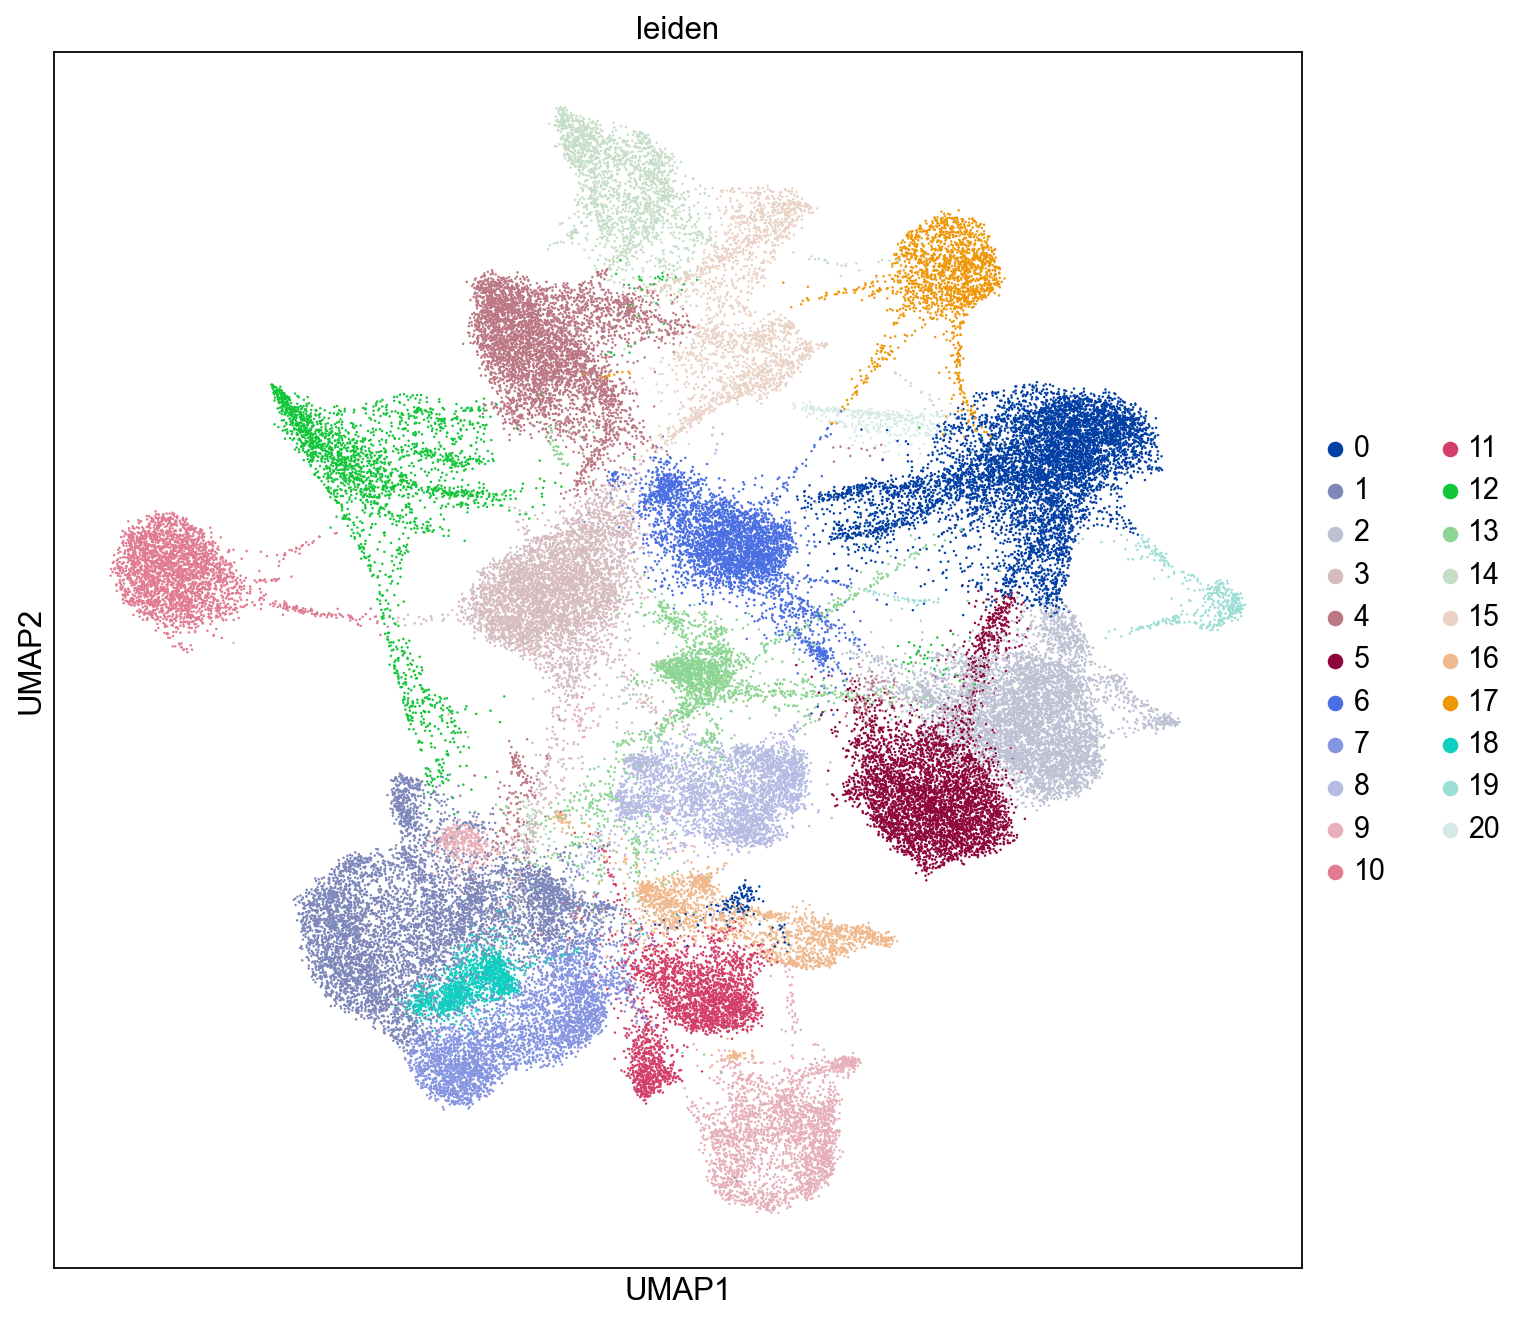

In [12]:
sc.set_figure_params(figsize=(10,10))
sc.pl.umap(adata, color = ['leiden'], size = 5)

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\squidpy\pl\_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


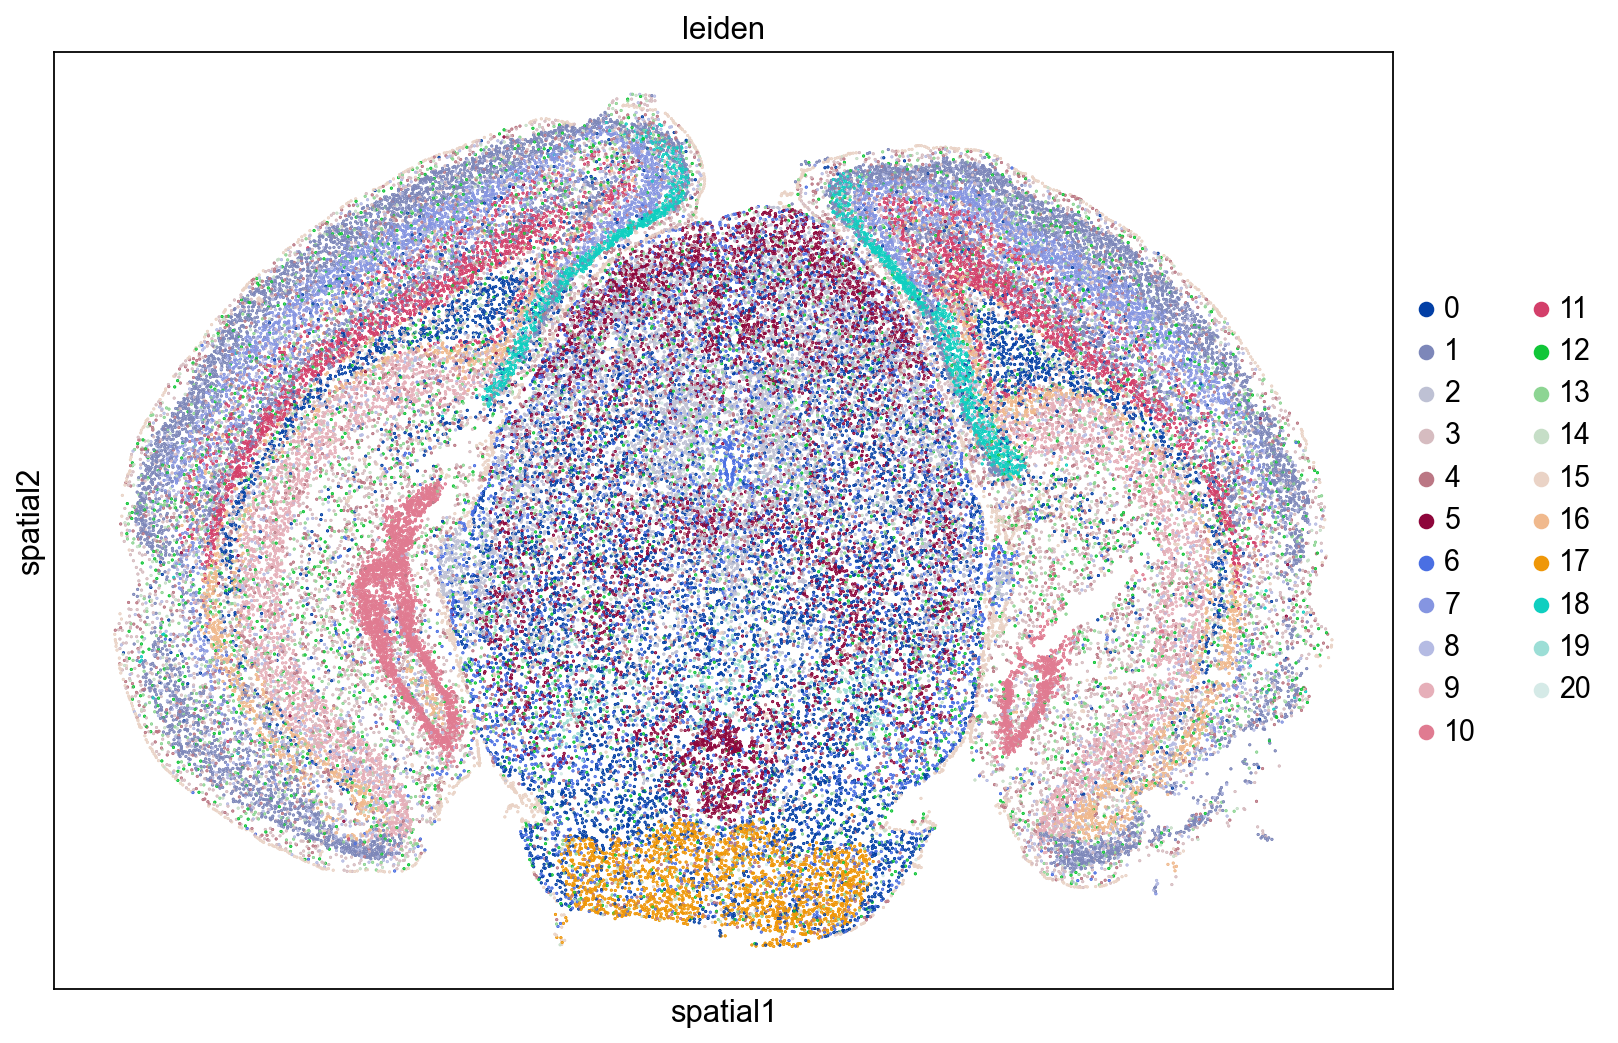

In [13]:
sq.pl.spatial_scatter(
    adata,
    shape = None, color = 'leiden', size = 0.5,
    library_id = 'spatial', figsize=(10,10))

In [14]:
markers = pd.read_csv(directory + 'neuro_panel_cluster_annotation.csv', index_col=0)
markers.index = markers.gene
markers.head()

gene     Class ClusterName                            Description  \
gene                                                                        
Igf2    Igf2  Vascular        VECA   Vascular endothelial cells, arterial   
Ngfr    Ngfr   Neurons      SYNOR4   Noradrenergic erector muscle neurons   
Ccnd2  Ccnd2   Neurons       SZNBL  Neuronal intermidate progenitor cells   
Th        Th   Neurons      SYNOR4   Noradrenergic erector muscle neurons   
Lhx2    Lhx2   Neurons     TEGLU13    Excitatory neurons, cerebral cortex   

                              Neurotransmitter  \
gene                                             
Igf2                                       NaN   
Ngfr                             Noradrenaline   
Ccnd2                                      NaN   
Th                               Noradrenaline   
Lhx2   Glutamate (VGLUT1,VGLUT2), Nitric oxide   

                                                 Region  
gene                                                     
Igf2                                                CNS  
Ngfr                               Sympathetic ganglion  
Ccnd2  Striatum dorsal, Striatum ventral, Dentate gyrus  
Th                                 Sympathetic ganglion  
Lhx2                                             Cortex

In [15]:
adata.var = pd.merge(adata.var, markers, how = 'left', left_index=True, right_index=True)

In [16]:
adata.var.Class.value_counts()

Class
Neurons           106
Vascular           13
Ependymal           5
Oligos              5
Astrocytes          5
Immune              4
PeripheralGlia      3
Name: count, dtype: int64

In [17]:
markers.Class.value_counts()

Class
Neurons           388
Vascular           30
Oligos             27
Ependymal          18
PeripheralGlia     18
Astrocytes         11
Immune              8
Name: count, dtype: int64

In [18]:
%%capture
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon')

In [19]:
%%capture
top_markers = pd.DataFrame()
for cluster in adata.obs['leiden'].unique():
    markers_ = adata.uns['rank_genes_groups']['names'][cluster][:10]
    scores = adata.uns['rank_genes_groups']['scores'][cluster][:10]
    top_markers = pd.concat([top_markers,pd.DataFrame({'cluster': [cluster]*10,
                                                   'gene': markers_,
                                                   'scores': scores})])

In [20]:
markers = markers.reset_index(drop = True)

In [21]:
top_markers = pd.merge(top_markers, markers, on = 'gene', how = 'left')

In [22]:
marker_table = pd.crosstab(top_markers.cluster, top_markers.Class)

In [23]:
labels = marker_table.idxmax(axis = 1)

In [24]:
labels.index = labels.index.astype(dtype = 'int')

In [25]:
labels = labels.sort_index()

In [26]:
labels.name = 'cluster_type'

In [27]:
adata.obs['cluster'] = adata.obs.leiden.astype('int')

In [28]:
adata.obs = pd.merge(adata.obs, labels, how = 'left', on = 'cluster')

In [29]:
adata.obs['cluster'] = adata.obs.leiden.astype('str') + '-' + adata.obs.cluster_type

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


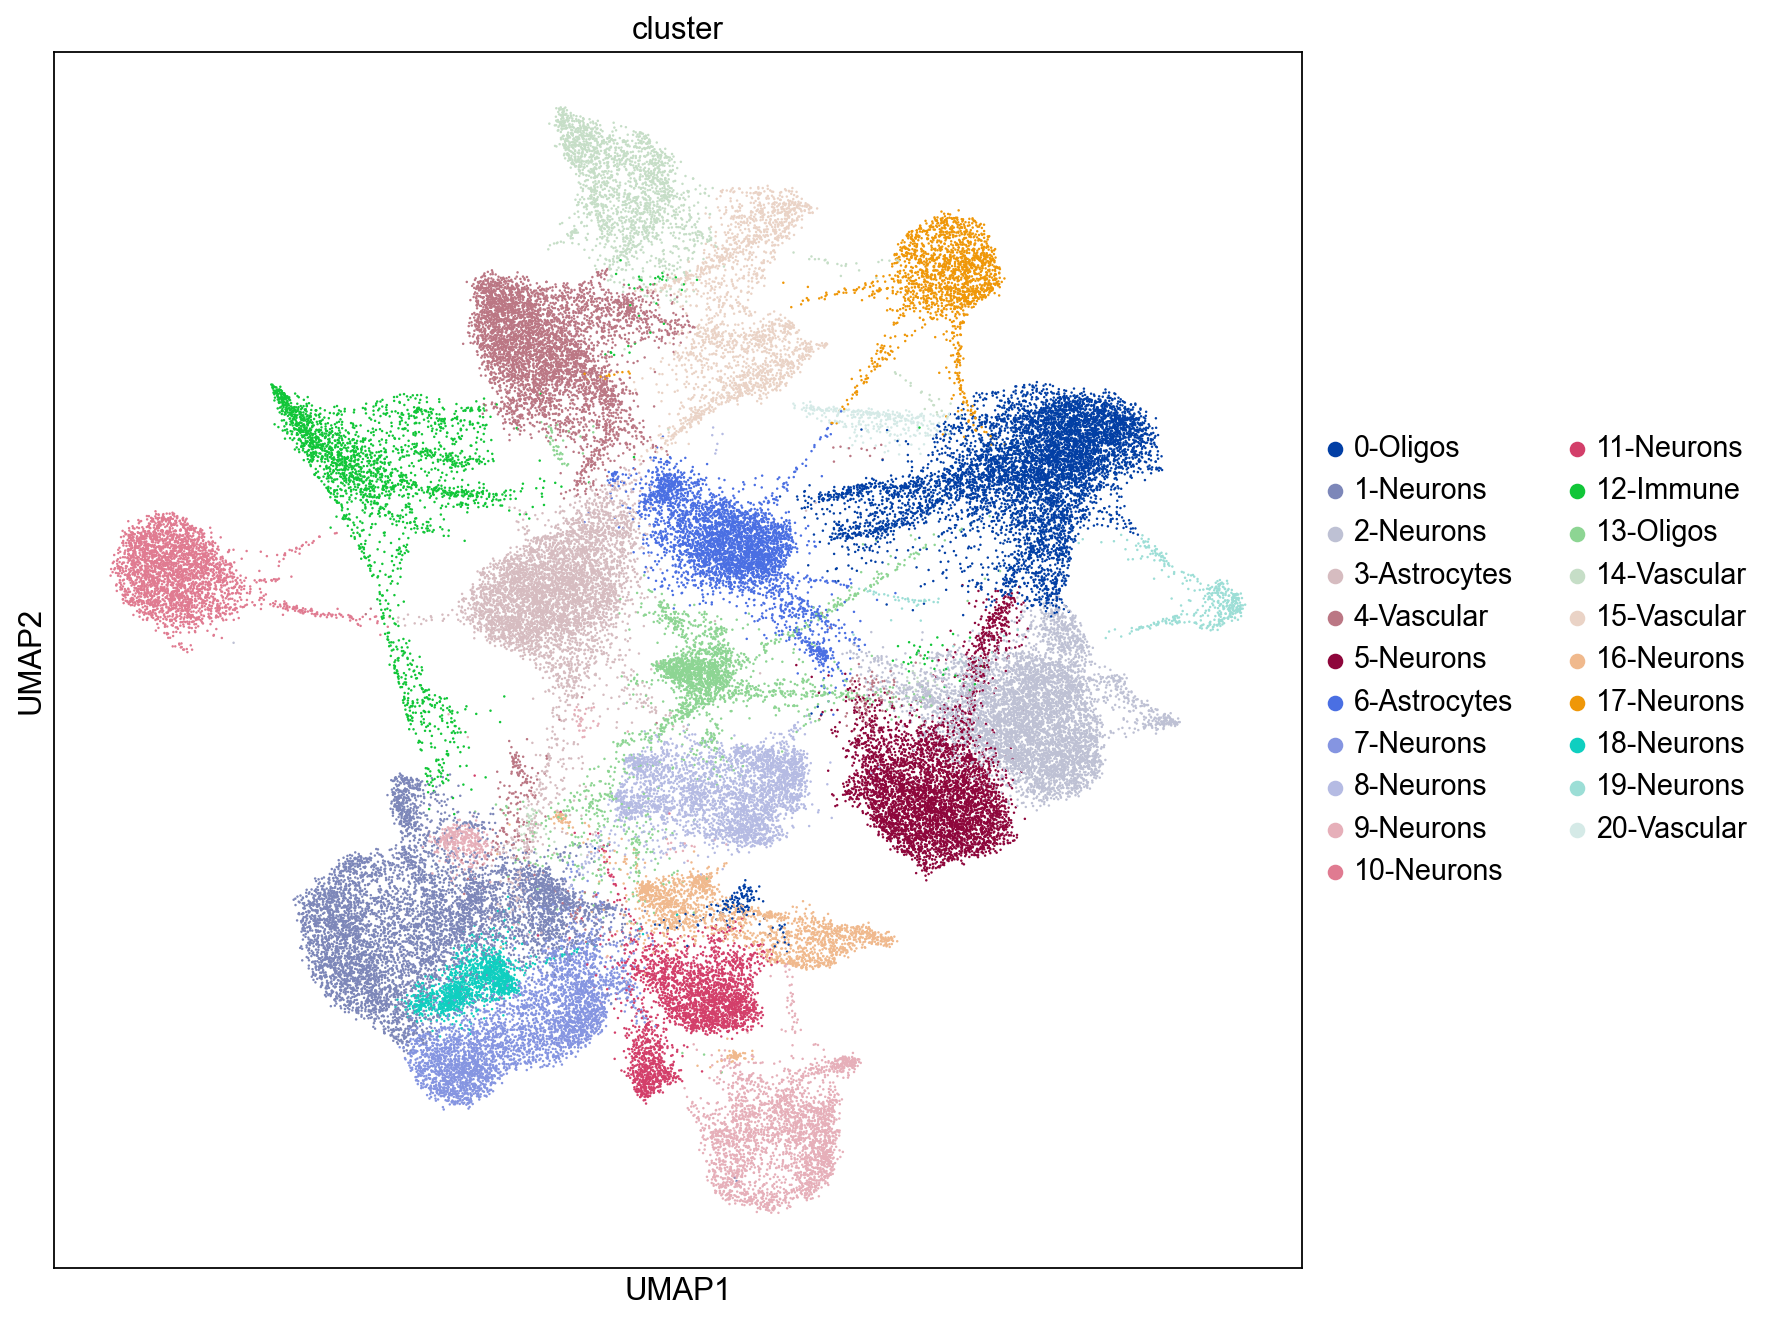

In [30]:
sc.pl.umap(adata, color = 'cluster', size = 5)

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\squidpy\pl\_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


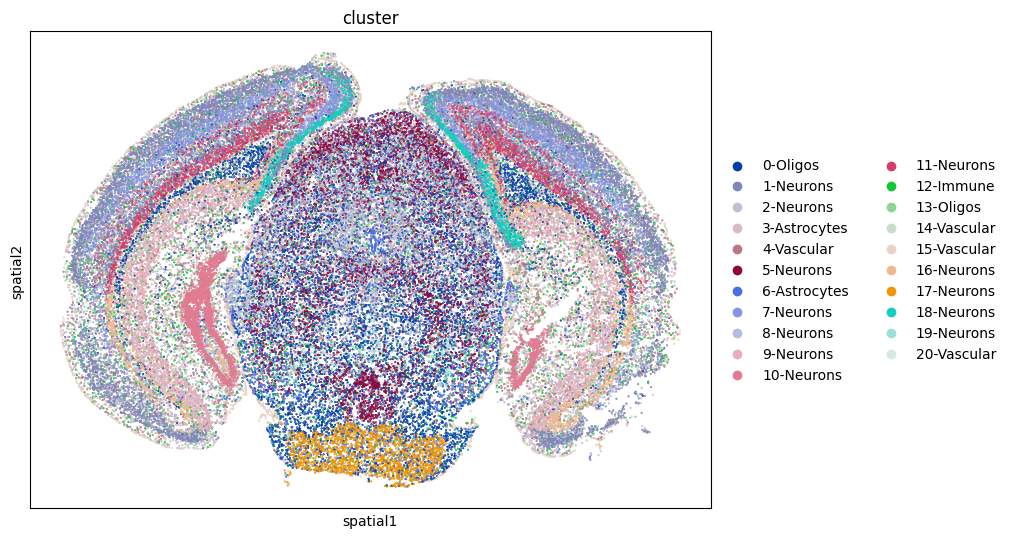

In [6]:
sq.pl.spatial_scatter(
    adata,
    shape = None, color = 'cluster', size = 0.5,
    library_id = 'spatial', figsize=(10,10))

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


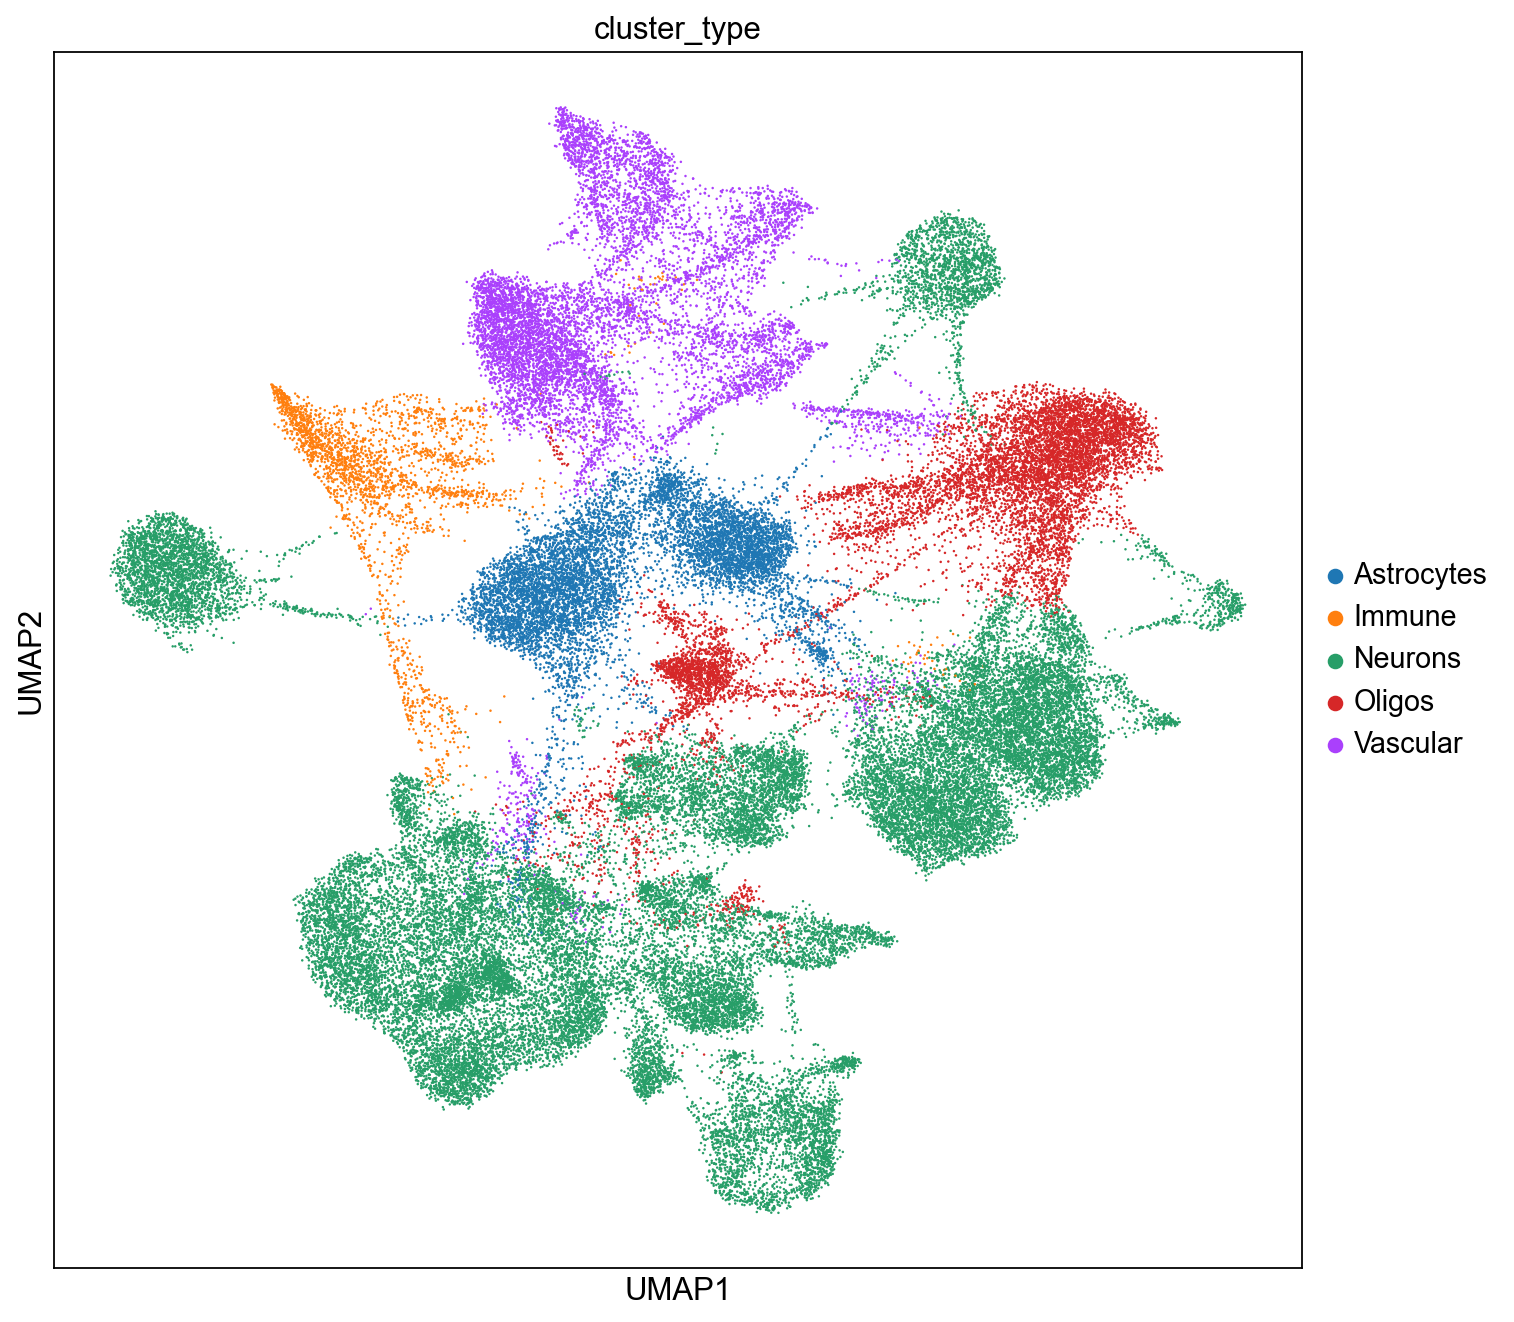

In [31]:
sc.pl.umap(adata, color = 'cluster_type', size = 5)

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\squidpy\pl\_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


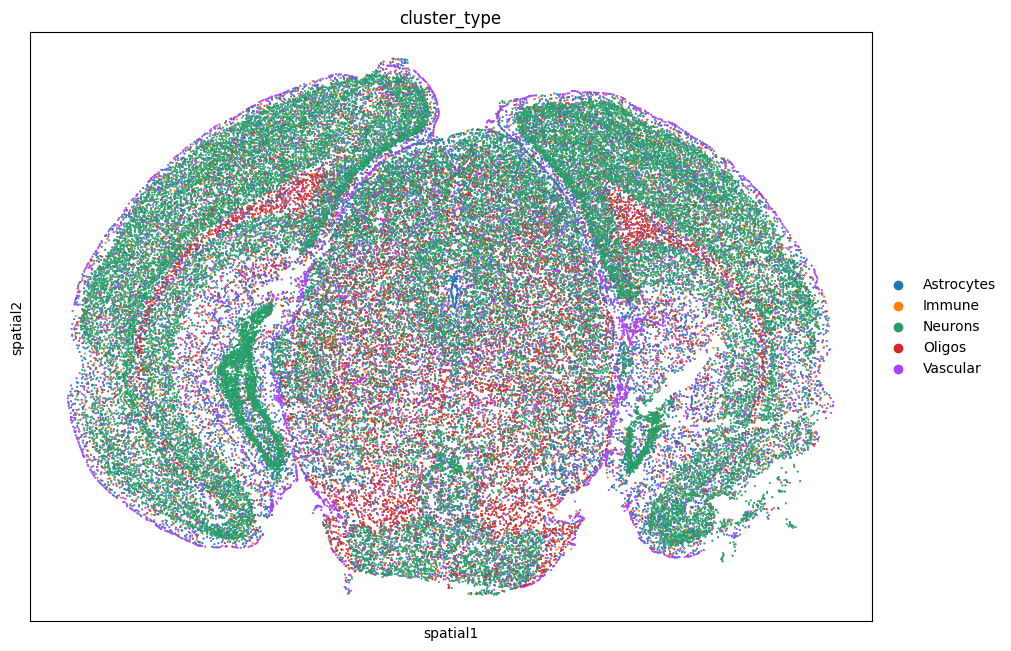

In [7]:
sq.pl.spatial_scatter(
    adata,
    shape = None, color = 'cluster_type', size = 0.5,
    library_id = 'spatial', figsize=(10,10))

In [32]:
sq.gr.spatial_neighbors(adata, coord_type = 'generic', spatial_key = 'spatial')
sq.gr.nhood_enrichment(adata, cluster_key = 'cluster')

  0%|          | 0/1000 [00:00<?, ?/s]

In [33]:
os.listdir()

['anndata.h5ad',
 'anndata.pickle',
 'cell_boundaries.parquet',
 'cell_by_gene.csv',
 'cell_metadata.csv',
 'images',
 'neuro_panel_cluster_annotation.csv',
 'partitioned_transcripts.csv',
 'spat.Rds']

In [34]:
with open('anndata.pickle', 'wb') as f:
    pickle.dump(adata, f)

In [1]:
# import cormerant as cmt
import numpy as np
import pandas as pd
import squidpy as sq
from copy import deepcopy
from scipy.cluster import hierarchy as sch
import scanpy as sc

from matplotlib import pyplot as plt
import os
import pickle
%matplotlib inline

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\DouglasHannumJr\anaconda3\lib\site-packages\spatialdata\__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


Going to follow the example [workflow](https://squidpy.readthedocs.io/en/stable/notebooks/examples/graph/compute_ligrec.html) provided by squidpy to run receptor-ligand analysis with a re-implementation of cellphonedb. 

In [2]:
directory = '/Users/DouglasHannumJr/Desktop/s3_bucket_data/s3_bucket_data/'

In [3]:
os.chdir(directory)
os.listdir()

['anndata.h5ad',
 'anndata.pickle',
 'cell_boundaries.parquet',
 'cell_by_gene.csv',
 'cell_metadata.csv',
 'images',
 'neuro_panel_cluster_annotation.csv',
 'partitioned_transcripts.csv',
 'spat.Rds']

In [4]:
with open('anndata.pickle', 'rb') as f:
    adata = pickle.load(f)

Receptor Ligand Stuff

In [5]:
adata

AnnData object with n_obs × n_vars = 67729 × 483
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'n_counts', 'leiden', 'cluster', 'cluster_type'
    var: 'n_cells', 'mean', 'std', 'gene', 'Class', 'ClusterName', 'Description', 'Neurotransmitter', 'Region'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'cluster_colors', 'cluster_type_colors', 'spatial_neighbors', 'cluster_nhood_enrichment'
    obsm: 'blank_genes', 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [6]:
adata.obs.head()

fov       volume        min_x        min_y        max_x        max_y  \
0  NaN   926.843300  7651.597166  3591.773372  7667.818766  3608.102973   
1  NaN  1068.359528  7822.885170  3682.169375  7835.639971  3693.314975   
2  NaN   519.714508  7799.557170  3745.457376  7809.082770  3757.790977   
3  NaN   560.521831  7696.201167  3708.953375  7704.106767  3720.422976   
4  NaN  1975.395430  7661.317166  3632.381373  7679.806767  3650.654974   

   anisotropy  transcript_count  perimeter_area_ratio  solidity  n_counts  \
0    1.380044               226              0.502872  3.257825     226.0   
1    1.307624               204              0.401261  5.802649     204.0   
2    1.437755               158              0.628701  4.245162     158.0   
3    1.527251               115              0.569795  5.278365     114.0   
4    1.200734               770              0.304745  4.898135     764.0   

  leiden       cluster cluster_type  
0      3  3-Astrocytes   Astrocytes  
1      3  3-Astrocytes   Astrocytes  
2      3  3-Astrocytes   Astrocytes  
3      4    4-Vascular     Vascular  
4      8     8-Neurons      Neurons

In [22]:
adata_sub = adata[adata.obs['min_x'] > 5000]

In [23]:
adata_sub

View of AnnData object with n_obs × n_vars = 29669 × 483
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'n_counts', 'leiden', 'cluster', 'cluster_type'
    var: 'n_cells', 'mean', 'std', 'gene', 'Class', 'ClusterName', 'Description', 'Neurotransmitter', 'Region'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'cluster_colors', 'cluster_type_colors', 'spatial_neighbors', 'cluster_nhood_enrichment'
    obsm: 'blank_genes', 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [24]:
res = sq.gr.ligrec(
    adata_sub,
    n_perms = 100,
    cluster_key = 'cluster',
    copy = True,
    use_raw = False,
    interaction_params={'resources':'CellPhoneDB'},
    transmitter_params ={'categories':'ligand'},
    receiver_params = {'categories':'receptor'})

  0%|          | 0/100 [00:00<?, ?permutation/s]

In [25]:
res['means'].shape

(107, 441)

In [26]:
res['means'].sum(axis=1)

source   target
KIT      PDGFRB    40.567856
NRP1     PDGFRB    53.153027
CXCL12   EPHB2     54.514167
FLT4     KDR       21.601169
NRP1     KDR       50.795039
                     ...    
SLC17A7  GRM6      39.142934
SLC17A8  GRM6       3.817010
SLC17A6  GRIN2B    45.490812
SLC17A7  GRIN2B    75.827596
SLC17A8  GRIN2B    14.858360
Length: 107, dtype: float64

In [27]:
res['pvalues'].head()

cluster_1     0-Oligos                                                      \
cluster_2     0-Oligos 1-Neurons 10-Neurons 11-Neurons 12-Immune 13-Oligos   
source target                                                                
KIT    PDGFRB      NaN       NaN        NaN        NaN       NaN       NaN   
NRP1   PDGFRB      NaN       NaN        NaN        NaN       NaN       NaN   
CXCL12 EPHB2       NaN       NaN        NaN        NaN       NaN       NaN   
FLT4   KDR         NaN       NaN        NaN        NaN       NaN       NaN   
NRP1   KDR         NaN       NaN        NaN        NaN       NaN       NaN   

cluster_1                                                    ...  9-Neurons  \
cluster_2     14-Vascular 15-Vascular 16-Neurons 17-Neurons  ... 19-Neurons   
source target                                                ...              
KIT    PDGFRB         NaN         NaN        NaN        NaN  ...        NaN   
NRP1   PDGFRB         NaN         NaN        NaN        NaN  ...        NaN   
CXCL12 EPHB2          NaN         NaN        NaN        NaN  ...        NaN   
FLT4   KDR            NaN         NaN        NaN        NaN  ...        NaN   
NRP1   KDR            NaN         NaN        NaN        NaN  ...        NaN   

cluster_1                                                              \
cluster_2     2-Neurons 20-Vascular 3-Astrocytes 4-Vascular 5-Neurons   
source target                                                           
KIT    PDGFRB       NaN         NaN          0.0        NaN       NaN   
NRP1   PDGFRB       NaN         NaN          0.0        NaN       NaN   
CXCL12 EPHB2        NaN         NaN          NaN        NaN       NaN   
FLT4   KDR          NaN         NaN          NaN        NaN       NaN   
NRP1   KDR          NaN         0.0          NaN        0.0       NaN   

cluster_1                                                 
cluster_2     6-Astrocytes 7-Neurons 8-Neurons 9-Neurons  
source target                                             
KIT    PDGFRB          0.0       NaN       NaN       NaN  
NRP1   PDGFRB          0.0       NaN       NaN       NaN  
CXCL12 EPHB2           NaN       NaN       NaN       NaN  
FLT4   KDR             NaN       NaN       NaN       NaN  
NRP1   KDR             NaN       NaN       NaN       NaN  

[5 rows x 441 columns]

In [28]:
res['metadata'].head()

aspect_intercell_source aspect_intercell_target  \
source target                                                   
KIT    PDGFRB              functional              functional   
NRP1   PDGFRB              functional              functional   
CXCL12 EPHB2               functional              functional   
FLT4   KDR                 functional              functional   
NRP1   KDR                 functional              functional   

              category_intercell_source category_intercell_target  \
source target                                                       
KIT    PDGFRB                    ligand                  receptor   
NRP1   PDGFRB                    ligand                  receptor   
CXCL12 EPHB2                     ligand                  receptor   
FLT4   KDR                       ligand                  receptor   
NRP1   KDR                       ligand                  receptor   

              category_source_intercell_source  \
source target                                    
KIT    PDGFRB                resource_specific   
NRP1   PDGFRB                resource_specific   
CXCL12 EPHB2                 resource_specific   
FLT4   KDR                   resource_specific   
NRP1   KDR                   resource_specific   

              category_source_intercell_target  consensus_direction  \
source target                                                         
KIT    PDGFRB                resource_specific                False   
NRP1   PDGFRB                resource_specific                False   
CXCL12 EPHB2                 resource_specific                 True   
FLT4   KDR                   resource_specific                False   
NRP1   KDR                   resource_specific                 True   

               consensus_inhibition  consensus_score_intercell_source  \
source target                                                           
KIT    PDGFRB                 False                                 1   
NRP1   PDGFRB                 False                                 2   
CXCL12 EPHB2                  False                                21   
FLT4   KDR                    False                                 1   
NRP1   KDR                    False                                 2   

               consensus_score_intercell_target  ...  scope_intercell_source  \
source target                                    ...                           
KIT    PDGFRB                                21  ...                 generic   
NRP1   PDGFRB                                21  ...                 generic   
CXCL12 EPHB2                                 20  ...                 generic   
FLT4   KDR                                   23  ...                 generic   
NRP1   KDR                                   23  ...                 generic   

               scope_intercell_target secreted_intercell_source  \
source target                                                     
KIT    PDGFRB                 generic                     False   
NRP1   PDGFRB                 generic                      True   
CXCL12 EPHB2                  generic                      True   
FLT4   KDR                    generic                      True   
NRP1   KDR                    generic                      True   

              secreted_intercell_target  \
source target                             
KIT    PDGFRB                     False   
NRP1   PDGFRB                     False   
CXCL12 EPHB2                      False   
FLT4   KDR                         True   
NRP1   KDR                         True   

                                                         sources  \
source target                                                      
KIT    PDGFRB  HPRD_MIMP;KEA;MIMP;NetworKIN_KEA;PhosphoSite_M...   
NRP1   PDGFRB                                          Cellinker   
CXCL12 EPHB2                                                Wang   
FLT4   KDR              HPRD;IntAct;Li20

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


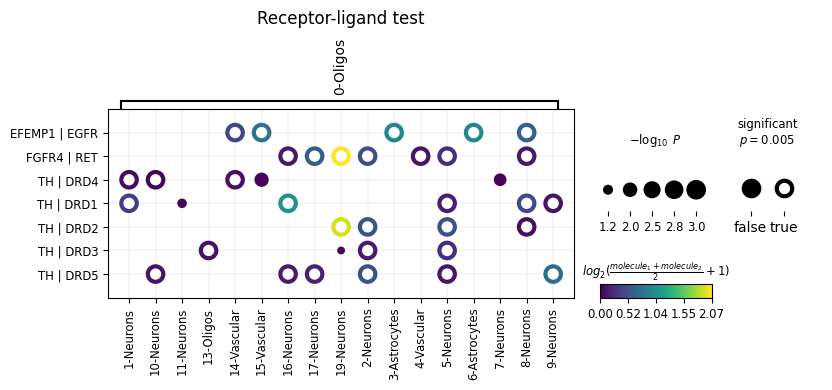

In [29]:
sq.pl.ligrec(res, source_groups = '0-Oligos', alpha = 0.005)